In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def get_cifar10_loaders(batch_size, partial=None, random=None):
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  
  if random is not None:
    temp = np.random.randint(10, size=len(trainset))
    trainset.targets = [int(label) for label in temp]

  if partial is not None:
    indices = np.arange(0,len(trainset))
    np.random.shuffle(indices)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=2, 
                                              sampler=torch.utils.data.SubsetRandomSampler(indices[:partial]))
  else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  return trainloader, testloader


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


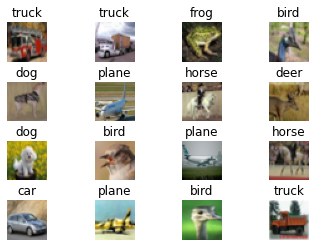

In [3]:
trainloader, _ = get_cifar10_loaders(256)

dataiter = iter(trainloader)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
S = 4

for i in range(S):
  for j in range(S):
    images, labels = dataiter.next()
    X = np.transpose(images[0].numpy()/2+0.5, (1, 2, 0))
    y = labels[0]

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(classes[y])
    plt.subplots_adjust(hspace = 0.5)

plt.show()

In [4]:
# trainloader = get_cifar10_loaders(256)
batch = next(iter(trainloader))[0]
# print(len(batch))
# print(len(batch[1]))
# print(type(item))
# print(item.size())
item = batch[0]
print(item.size())
item = item.permute(1,2,0)
print(item.size())

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


In [5]:
from sklearn.feature_extraction import image
patches = image.extract_patches_2d(item, (16, 16))
print('Patches shape: {}'.format(patches.shape))
patches = torch.from_numpy(patches)
patches = patches.permute(0,3,1,2)

# print(item[:5,:5,:])
# print(patches[0])

Patches shape: (289, 16, 16, 3)


torch.Size([3, 16, 16])
(16, 16, 3)


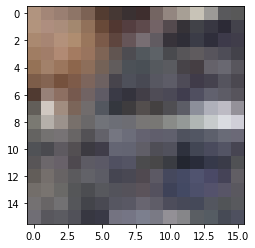

In [6]:
print(patches[0].size())
X = np.transpose(patches[285].numpy()/2+0.5, (1, 2, 0))
print(X.shape)
plt.imshow(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


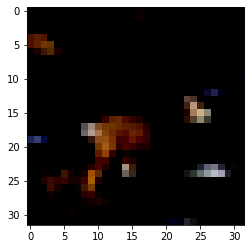

In [7]:
X = np.transpose(item.numpy()/2+0.5, (0, 1, 2))
plt.imshow(item.numpy())

In [8]:
from sklearn.feature_extraction import image

def create_patches_data(trainloader, patch_size):
  # 32x32 images in CIFAR10, stride is 1
  num_patches_per_image = ((32 - patch_size + 1)**2)
  # 3 channels  
  flattened_patches_length = (patch_size**2) * 3
  data_matrix = None
  # np.empty((num_images, flattened_patches_length))
  batch = 1
  patches_list = []
  for data in trainloader:
#     print("batch: {}".format(batch))
    inputs, labels = data
    # print(inputs.size())
    for i in range(len(inputs)):
      img = inputs[i]
      img = img.permute(1,2,0)
      # print(img.size())
      patches = image.extract_patches_2d(img, (patch_size, patch_size))
      patches_list.append(patches)
      # print(type(patches))
      # print(patches.shape)
#       patches = patches.reshape((num_patches_per_image, flattened_patches_length))
#       if data_matrix is None:
#         data_matrix = patches
#       else:
#         data_matrix = np.concatenate((data_matrix, patches), axis=0)
    batch+=1
      # for j in range(patches.shape[0]):
      #   print(patches[j].reshape(1,-1).shape)
      #   data_matrix = np.hstack((data_matrix, patches[j].reshape(1,-1)))
  patches_list = np.stack(patches_list, axis=0)
  print(patches_list.shape)
  data_matrix = np.reshape(patches_list, (-1, flattened_patches_length))
  print(data_matrix.shape)
  return data_matrix
  # print('Patches shape: {}'.format(patches.shape))
  # patches = torch.from_numpy(patches)
  # patches = patches.permute(0,3,1,2)
  # print(item[:5,:5,:])
  # print(patches[0])


In [9]:
from numpy import linalg as LA

def create_eigs(data):
  cov_matrix = np.cov(data , rowvar=False)
  print(cov_matrix.shape)

  w, v = LA.eig(cov_matrix)
  print(w.shape)
  print(v.shape)
  return w,v

# num_images = 1000
patch_size = 3
trainloader, _ = get_cifar10_loaders(256, partial=30000)
patches_data = create_patches_data(trainloader, patch_size)
eig_vals, eig_vecs = create_eigs(patches_data)

Files already downloaded and verified
Files already downloaded and verified
(30000, 900, 3, 3, 3)
(27000000, 27)
(27, 27)
(27,)
(27, 27)


In [10]:
np.save("patches_data.npy", patches_data)
np.save("eig_vals.npy", eig_vals)
np.save("eig_vecs.npy", eig_vecs)

In [11]:
from torch import nn
# import random     

class SimpleCNN(nn.Module):
  def __init__(self, num_conv_layers, num_filters, num_units, num_output, 
               img_width, img_height):
    super(SimpleCNN, self).__init__()
    torch.manual_seed(501)
    # random.seed(501)
    np.random.seed(501)

    self.conv = nn.Sequential()
    for i in range(num_conv_layers):
      self.conv.add_module("conv_{}".format(i), nn.Conv2d(
          in_channels=3, out_channels=num_filters, 
          kernel_size=3, stride=1, padding=0))
      self.conv.add_module("relu_{}".format(i), nn.ReLU())
    last_size = (img_width-num_conv_layers*2) * (img_height-num_conv_layers*2) \
                * num_filters
    self.fc = nn.Linear(last_size, num_units)
    self.classifier = nn.Linear(num_units, num_output)

  def forward(self, x):
    forward = nn.Sequential(self.conv, nn.Flatten(),
                            self.fc, nn.ReLU(),
                            self.classifier)
    x = forward(x)
    ###########################################################
    #                         END OF YOUR CODE                #
    ###########################################################
    return x

In [12]:
from numpy.linalg import multi_dot
from numpy.linalg import inv

def calculate_misalignment(data_eig_vecs, weights):
  weights = np.reshape(weights, (weights.shape[0], -1))
#   print(weights.shape)
  cov_weights = np.cov(weights , rowvar=False)
#   print(cov_weights.shape)
  res = 0
  for i in range(data_eig_vecs.shape[0]):
    a = multi_dot([data_eig_vecs[:,i].T, cov_weights, data_eig_vecs[:,i]])
    b = multi_dot([data_eig_vecs[:,i].T, inv(cov_weights), data_eig_vecs[:,i]])
    res += np.sqrt(a*b) - 1
  return res

def train(model, criterion, optimizer, epochs, dataloader, device, scheduler=None, verbose=True):
  loss_history = []
  misalignments = []
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):     
      # print("{}.th batch".format(i))
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      misalignments.append(calculate_misalignment(eig_vecs, model.conv.conv_0.weight.detach().numpy()))
      loss_history.append(loss.item())
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

    if scheduler is not None:
      scheduler.step()
      # Print Learning Rate
      print('Epoch:', epoch,'LR:', scheduler.get_last_lr())

    # for name, param in model.named_parameters():
    #   print(name, param.grad)
  return loss_history, misalignments


In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def get_training_components(learnable_params, init_lr, step_size=None, gamma=None):
  '''
  Function to prepare components of the training. These are all the same
  throughout the experiments made.
  '''
  # The problem always be a image classification
  criterion = nn.CrossEntropyLoss()
  # Which parameters to be updated depends on if the training is done from scratch
  # or with pre-trained model.
  optimizer = optim.SGD(learnable_params, lr=init_lr, momentum=0.9)
  # Step size depends on the # of epoch
  if step_size is not None:
    scheduler = StepLR(optimizer, step_size, gamma)
    return (criterion, optimizer, scheduler)
  return (criterion, optimizer)

def get_device():
  if torch.cuda.is_available():
    print("Cuda (GPU support) is available and enabled!")
    device = torch.device("cuda")
  else:
    print("Cuda (GPU support) is not available :(")
    device = torch.device("cpu")

def get_learnable_parameters(model):
  params_to_update = []
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      # print(name)
      params_to_update.append(param)
  return params_to_update


In [14]:
# Misalignment between data and real-label-trained filters
simple_cnn = SimpleCNN(1, 256, 64, 10, 32, 32)

trainloader, _ = get_cifar10_loaders(256)

device = get_device()
simple_cnn = simple_cnn.to(device)
simple_cnn.train()
epochs = 40
learning_rate = 0.01

learnable_parameters = get_learnable_parameters(simple_cnn)
criterion, optimizer = get_training_components(learnable_parameters, learning_rate)
loss_history, misalignments_train_real = train(simple_cnn, criterion, optimizer, epochs, trainloader, device)

Files already downloaded and verified
Files already downloaded and verified
Cuda (GPU support) is available and enabled!
Epoch 0 / 40: avg. loss of last 5 iterations 1.4192804098129272
Epoch 1 / 40: avg. loss of last 5 iterations 1.2556463718414306
Epoch 2 / 40: avg. loss of last 5 iterations 1.0995572566986085
Epoch 3 / 40: avg. loss of last 5 iterations 0.9451073169708252
Epoch 4 / 40: avg. loss of last 5 iterations 0.8275872111320496
Epoch 5 / 40: avg. loss of last 5 iterations 0.739946985244751
Epoch 6 / 40: avg. loss of last 5 iterations 0.6779179334640503
Epoch 7 / 40: avg. loss of last 5 iterations 0.5909932374954223
Epoch 8 / 40: avg. loss of last 5 iterations 0.5399114310741424
Epoch 9 / 40: avg. loss of last 5 iterations 0.4468078076839447
Epoch 10 / 40: avg. loss of last 5 iterations 0.3727102518081665
Epoch 11 / 40: avg. loss of last 5 iterations 0.33457932472229
Epoch 12 / 40: avg. loss of last 5 iterations 0.3070871472358704
Epoch 13 / 40: avg. loss of last 5 iterations 0

In [ ]:
# Misalignment between data and random-label-trained filters
simple_cnn = SimpleCNN(1, 256, 64, 10, 32, 32)

trainloader, _ = get_cifar10_loaders(256, random=True)

device = get_device()
simple_cnn = simple_cnn.to(device)
simple_cnn.train()
epochs = 40
learning_rate = 0.001

learnable_parameters = get_learnable_parameters(simple_cnn)
criterion, optimizer = get_training_components(learnable_parameters, learning_rate)
loss_history, misalignments_train_random = train(simple_cnn, criterion, optimizer, epochs, trainloader, device)

Files already downloaded and verified
50000
(50000,)
Files already downloaded and verified
Cuda (GPU support) is available and enabled!
Epoch 0 / 40: avg. loss of last 5 iterations 2.3065045356750487
Epoch 1 / 40: avg. loss of last 5 iterations 2.3024501323699953
Epoch 2 / 40: avg. loss of last 5 iterations 2.3023332595825194
Epoch 3 / 40: avg. loss of last 5 iterations 2.300066375732422
Epoch 4 / 40: avg. loss of last 5 iterations 2.3024434089660644
Epoch 5 / 40: avg. loss of last 5 iterations 2.2991891860961915
Epoch 6 / 40: avg. loss of last 5 iterations 2.3013988971710204
Epoch 7 / 40: avg. loss of last 5 iterations 2.3000975608825684
Epoch 8 / 40: avg. loss of last 5 iterations 2.2988131999969483
Epoch 9 / 40: avg. loss of last 5 iterations 2.2956374645233155
Epoch 10 / 40: avg. loss of last 5 iterations 2.2994272232055666
Epoch 11 / 40: avg. loss of last 5 iterations 2.2903220653533936
Epoch 12 / 40: avg. loss of last 5 iterations 2.296030044555664
Epoch 13 / 40: avg. loss of las

In [ ]:
import matplotlib.pyplot as plt # For plotting
%matplotlib inline

plt.plot(misalignments_train_real)
plt.plot(misalignments_train_random)
plt.xlabel('# of iterations')
plt.ylabel('Misalignment')
plt.show()